# Analysing Billboard Year-End Top 100 Singles from 1960-2017

### Questions Asked:
<li>What makes a song popular? Are there certain audio features common to all popular songs?
<li>How has popular music changed since the sixties? Has it become quieter? Are there more words per track? 
<li>Has the content of lyrics changed over the years?

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import requests
import pandas as pd
import json

### Web Scraping
#### Scraped https://www.billboard.com/charts/year-end/ and Wikipedia to get Billboard Year End Hot 100 Singles

#### Scraping Wikipedia (Top Songs 1960-2006)

(Data of Top Songs before 2006 is not available on Billboard.com, so this data was scraped from Wikipedia.com)

In [ ]:
i
from bs4 import BeautifulSoup
music_list = []
df1= pd.DataFrame()
for year in range(1960,2006):
    if year != 1970:
        df_list = pd.read_html("https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_"+ str(year), header=0)
        df4= df_list[0]

        df4["Year"] = year
        if "№" in df4.columns:
            del df4["№"]
        if "No." in df4.columns:
            del df4["No."]
     
        for index, row in df4.iterrows():
            try:
                row["Title"]=  json.loads(row["Title"])
            except:
                pass
            music_list.append(row.values.tolist())



#### Scraping Billboard (Top Songs 2006-2017)

In [ ]:
# For 2006 to 2017
import requests
from bs4 import BeautifulSoup
for year in range(2006,2018):
    url = "https://www.billboard.com/charts/year-end/"+ str(year)+"/hot-100-songs"
    response = requests.get(url)
    results_page = BeautifulSoup(response.content,'lxml')
    # print(results_page.prettify())
    article_tags = results_page.find_all('article', class_= "ye-chart-item")
    for tag in article_tags:
        artist =tag.find('div', class_= "ye-chart-item__artist").get_text().strip()
        track  = tag.find('div', class_= "ye-chart-item__title").get_text().strip()
        music_list.append([track,artist, year])

### Use Spotify API https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/ to get Audio Features of Tracks

NOTE: DESCRIPTION OF AUDIO FEATURES CAN ALSO BE FOUND ON THE LINK ABOVE

#### Define function to get Audio Features from Spotify

In [ ]:

def get_spotify_features(track, artist):
    import spotipy
    import numpy as np
    from spotipy.oauth2 import SpotifyClientCredentials
    client_credentials_manager = SpotifyClientCredentials(client_id="a31e2c1446fd4e6aa11476d8532fc939",client_secret="b52f884f9d4f464eba58daf0d5180ea4")
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    from collections import OrderedDict
    #Search for Spofity track id
    songs=sp.search(q='track:'+track+' '+'artist:'+artist+'*' , type='track')
    items = songs['tracks']['items']
    if len(items) ==0:
        return([0]*18)
    else:
        track = items[0]
        song_id = str(track["id"])
        #Use Spotify Track ID to get Track features
        track_features=sp.audio_features(song_id)
        if len(track_features[0]) <18:
            return([0]*18)
        else:
            features = np.array(track_features)[0]
            #Order Dictionary
            features = OrderedDict(features)
            return(features.values())

#### Use the get_spotify_features function defined above to get Audio Features for Tracks

Names of tracks and artists were saved in music_list through webscraping earlier

In [ ]:
audio_features = []
for i in range(0,len(music_list)):
    print(i)
    try:
        year = music_list[i][2]
        track = music_list[i][0]
        artist= music_list[i][1]
        get_spotify_features(track,artist)
        
        danceability, energy, key, loudness, mode,speechiness,acousticness, instrumentalness, liveness, valence, tempo, type_, id_,uri, track_href,analysis_url,duration_ms, time_signature = get_spotify_features(track, artist)
        audio_features.append((year,artist,track,danceability, energy, key, loudness, mode, speechiness,acousticness, instrumentalness, liveness, valence, tempo,duration_ms, time_signature))
    except:
        pass

#### Convert the list of Audio Features that was extracted into a dataframe

In [ ]:
import pandas as pd
labels = ["Year", "Artist", "Track", "Danceability","Energy", "Key", "Loudness", "Mode", "Speechiness", "Acousticness",
          "Instrumentalness", "Liveness", "Valence", "Tempo", "Duration_ms", "Time_Signature"]
df =pd.DataFrame(audio_features, columns=labels)
df.head(50)

#### Save the dataframe to a CSV/Excel file

In [ ]:
# df.to_excel("spotify_project_final.xlsx")
# df.to_csv("spotify_project_final.csv", sep='\t')

Thought of Adding Another Feature

#### Define function to Get Popularity of Top Artists from Spotify

In [ ]:
def get_popularity(track, artist):
    import spotipy
    import numpy as np
    from spotipy.oauth2 import SpotifyClientCredentials
    client_credentials_manager = SpotifyClientCredentials(client_id="a31e2c1446fd4e6aa11476d8532fc939",client_secret="b52f884f9d4f464eba58daf0d5180ea4")
    from collections import OrderedDict

    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    artists=sp.search('artist:'+artist+'*' , type='artist')
    try:
        artist_popularity = artists['artists']['items'][0]['popularity']
    except:
        artist_popularity = 0
        
    songs=sp.search(q='track:'+track+' '+'artist:'+artist+'*' , type='track')
    items = songs['tracks']['items']
    if len(items) ==0:
        return([0]*18)
        song_popularity = 0
    else:
        track = items[0]
#         print(track)
        song_id = str(track["id"])
        song_popularity = track['popularity']
    return (song_popularity, artist_popularit

#### Use the get_popularity function to get popularity of artists from Spotify


In [ ]:
popularity=[]
for i in range(0,len(music_list)):
    try:
        year = music_list[i][2]
        track = music_list[i][0]
        artist= music_list[i][1]
     
        song_popularity, artist_popularity= get_popularity(track, artist)
        popularity.append((track, song_popularity, artist_popularity))
    except:
        pass

 Note:  Data is Saved Locally after Scraping Once

## Loading Final File and Beginning Analysis 

#### A SNEAK PEAK AT THE FINAL DATAFRAME

Note: All songs are not available on Spotify

In [2]:
import pandas as pd
import numpy as np
data_sp = pd.read_excel("spotify_project_final v2.0.xlsx")

### Some of the songs were missing audiofeatures, they are removed
data = data_sp[data_sp["Danceability"] !=0]

print(len(data))

data_sp.head(20)

4943


,Year,Artist,Track,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time_Signature,Track_Popularity,Artist_Popularity
0,1960,Percy Faith,Theme from A Summer Place,0.466,0.3890,5,-12.825,1,0.0253,0.631,0.843000,0.2950,0.749,92.631,144893,4,52,50
1,1960,Jim Reeves,Hell Have to Go,0.554,0.1860,1,-15.846,1,0.0379,0.909,0.001440,0.1100,0.200,81.181,138640,3,58,58
2,1960,The Everly Brothers,Cathys Clown,0.498,0.5820,7,-8.961,1,0.0339,0.412,0.000000,0.3720,0.866,119.809,144013,4,51,61
3,1960,Johnny Preston,Running Bear,0.772,0.2970,5,-14.679,0,0.0530,0.854,0.000008,0.1250,0.822,119.987,158200,4,39,34
4,1960,Mark Dinning,Teen Angel,0.570,0.0636,0,-18.548,1,0.0459,0.936,0.000000,0.1220,0.282,101.517,159893,4,22,22
5,1960,Brenda Lee,Im Sorry,0.558,0.2230,10,-12.362,1,0.0299,0.868,0.000972,0.1300,0.303,101.711,161547,3,56,67
6,1960,Elvis Presley,Its Now or Never,0.643,0.4910,4,-9.312,1,0.0344,0.642,0.009720,0.2860,0.753,126.399,194600,4,57,79
7,1960,Jimmy Jones,Handy Man,0.452,0.6440,10,-9.061,1,0.0490,0.376,0.000000,0.1960,0.854,144.995,125160,4,28,42
8,1960,Elvis Presley,Stuck on You,0.647,0.5130,7,-12.372,1,0.0421,0.758,0.000009,0.1080,0.955,131.641,139640,4,59,79
9,1960,Chubby Checker,The Twist,0.533,0.6380,4,-7.130,1,0.0341,0.202,0.000000,0.0729,0.937,156.663,153760,4,58,54


#### CHANGE SONG DURATION FROM MILLISECONDS TO MINUTES

In [3]:
# convert song duration from milliseconds to minutes
data["Duration"] = data["Duration_ms"].apply(lambda x: x/60000)
# data.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Year,Artist,Track,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Time_Signature,Track_Popularity,Artist_Popularity,Duration
0,1960,Percy Faith,Theme from A Summer Place,0.466,0.3890,5,-12.825,1,0.0253,0.631,0.843000,0.295,0.749,92.631,144893,4,52,50,2.414883
1,1960,Jim Reeves,Hell Have to Go,0.554,0.1860,1,-15.846,1,0.0379,0.909,0.001440,0.110,0.200,81.181,138640,3,58,58,2.310667
2,1960,The Everly Brothers,Cathys Clown,0.498,0.5820,7,-8.961,1,0.0339,0.412,0.000000,0.372,0.866,119.809,144013,4,51,61,2.400217
3,1960,Johnny Preston,Running Bear,0.772,0.2970,5,-14.679,0,0.0530,0.854,0.000008,0.125,0.822,119.987,158200,4,39,34,2.636667
4,1960,Mark Dinning,Teen Angel,0.570,0.0636,0,-18.548,1,0.0459,0.936,0.000000,0.122,0.282,101.517,159893,4,22,22,2.664883


### CALCULTING THE MEAN FOR EACH AUDIO FEATURE PER YEAR

In [5]:
# Create a zeros array to store averages later 
a=np.zeros((14,58))

df = pd.DataFrame(data[data['Year']==1960].mean())
means = pd.DataFrame(a, columns=range(1960,2018))

for year in range(1960,2018):
    df = pd.DataFrame(data[data['Year']==year].mean())
    for i in range(0,17):
        means.ix[i,year]=df.ix[i,0]
means=means.drop([0])

index_=df.index.values
newindex = list(filter(lambda x : x != 'Year', index_))

means.index=newindex
means

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Danceability,0.551031,0.545704,0.550633,0.549887,0.555489,0.552371,0.562542,0.538677,0.563082,0.549755,...,0.621258,0.629130,0.620567,0.624197,0.646480,0.615523,0.606957,0.647833,0.649889,0.696211
Energy,0.467871,0.474910,0.484974,0.517121,0.568352,0.573124,0.564792,0.531167,0.547804,0.508378,...,0.718015,0.717260,0.730030,0.736970,0.737467,0.708923,0.707174,0.668727,0.627611,0.611456
Key,5.093750,4.857143,5.408163,5.216495,4.922222,4.886598,5.208333,5.375000,4.938144,5.438776,...,5.909091,5.311688,5.417910,5.606061,5.400000,5.169231,5.681159,5.015152,5.825397,5.263158
Loudness,-10.717042,-10.910408,-10.299194,-10.228041,-9.647611,-9.527268,-9.971521,-9.737990,-10.378103,-10.974214,...,-5.298485,-5.239403,-5.023209,-5.308848,-5.195667,-5.578738,-5.464000,-5.870864,-6.353254,-6.514298
Mode,0.854167,0.877551,0.816327,0.865979,0.811111,0.855670,0.812500,0.854167,0.773196,0.714286,...,0.651515,0.701299,0.731343,0.742424,0.640000,0.723077,0.768116,0.681818,0.539683,0.561404
Speechiness,0.044937,0.062063,0.061243,0.055970,0.051287,0.043029,0.047257,0.040638,0.052971,0.047496,...,0.069036,0.073721,0.078148,0.068779,0.074348,0.063337,0.072077,0.075758,0.116467,0.129486
Acousticness,0.654333,0.646010,0.618762,0.573362,0.493947,0.445346,0.365832,0.406446,0.380327,0.355482,...,0.129395,0.140850,0.125109,0.114139,0.119668,0.118021,0.160909,0.167805,0.177620,0.151748
Instrumentalness,0.050696,0.100253,0.089676,0.060225,0.058431,0.048412,0.040888,0.033651,0.097226,0.045004,...,0.006137,0.005651,0.004809,0.027167,0.001374,0.009629,0.023394,0.001310,0.000329,0.004524
Liveness,0.181199,0.239024,0.198166,0.216604,0.196099,0.207451,0.201025,0.191609,0.212205,0.192888,...,0.167023,0.180582,0.184796,0.188921,0.170508,0.180397,0.175120,0.162379,0.152368,0.131142
Valence,0.685437,0.684163,0.669388,0.714928,0.697076,0.679763,0.706990,0.650219,0.661905,0.654010,...,0.504177,0.529104,0.553955,0.544858,0.564440,0.519492,0.505723,0.503591,0.469175,0.496177


### Change in Average Song Duration Over the Years

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


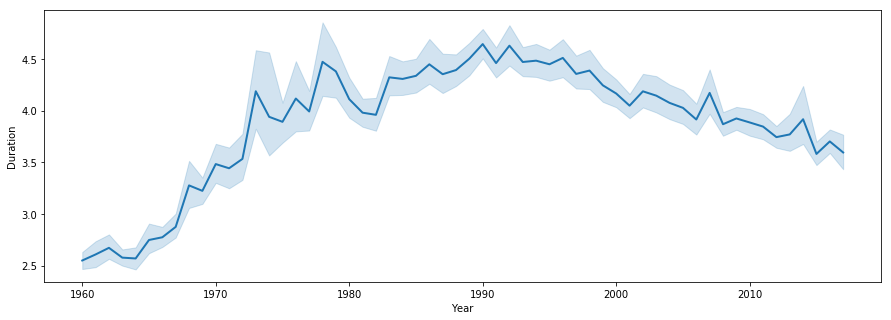

In [7]:
plt.figure(figsize=(15,5))
sns.lineplot(x="Year", y="Duration", data=data, lw=2)

### Change in Beats per Minute Over The Years

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


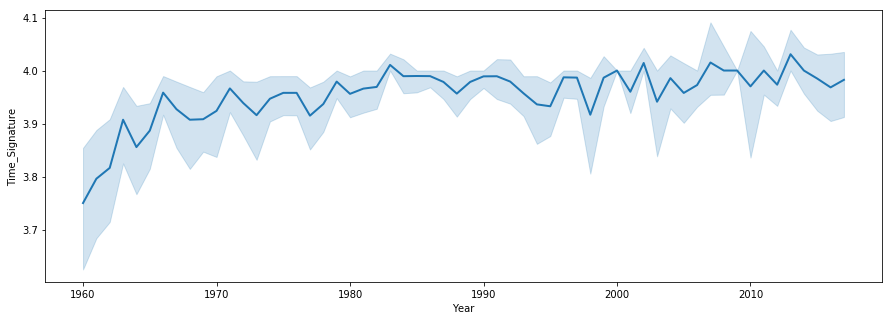

In [8]:
plt.figure(figsize=(15,5))
sns.lineplot(x="Year", y="Time_Signature", data=data, lw=2)

### Decline in Instrumentalness Since 80s

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0,0.5,'Instrumentalness')

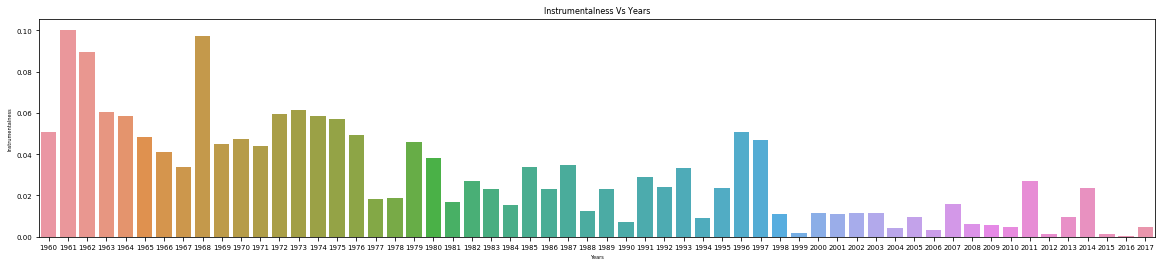

In [4]:
x=list(range(1960,2018))
y=list(pd.Series(means.ix['Instrumentalness',:]))
sns.set_context(rc={"font.size":7,"axes.titlesize":8,"axes.labelsize":5}) 
plt.figure(figsize=(20,4))
sns.barplot(x,y, ci=1)
plt.title('Instrumentalness Vs Years')
plt.xlabel('Years')
plt.ylabel('Instrumentalness')

### AVERAGE INSTRUMENTALNESS IN 2000s IS LESS THAN ONE FOURTH OF WHAT IT WAS BEFORE!

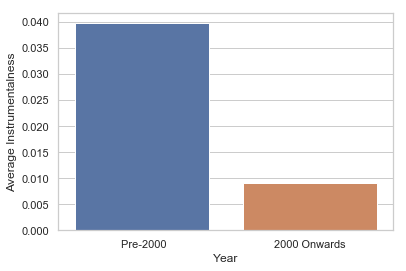

In [8]:
pre=data[data["Year"]<2000].Instrumentalness.mean()
post=data[data["Year"]>=2000].Instrumentalness.mean()
_list= []
_list.append((" Pre-2000",pre))
_list.append(("2000 Onwards", post))
smalldf = pd.DataFrame(_list)
smalldf.columns =["Year", "Average Instrumentalness"]

import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))

sns.barplot(x="Year", y="Average Instrumentalness", data=smalldf)

### Loudness has Decreased Drastically 90s Onwards

This can be attributed to the decline in number of rock and metal bands and rise of softer genres

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Text(0,0.5,'Loudness')

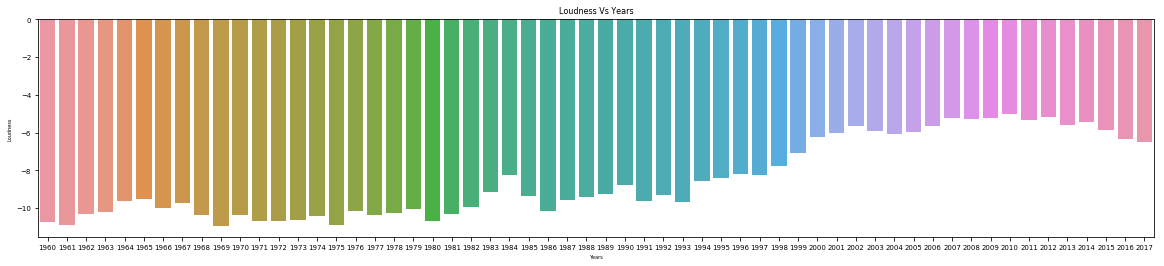

In [5]:
y=list(pd.Series(means.ix['Loudness',:]))
x=list(range(1960,2018))
plt.figure(figsize=(20,4))
sns.set_context(rc={"font.size":7,"axes.titlesize":8,"axes.labelsize":5})   
sns.barplot(x,y, ci=1)
plt.title('Loudness Vs Years')
plt.xlabel('Years')
plt.ylabel('Loudness')

### Words Per Song Have Increased due to rise of rap!

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Text(0,0.5,'Speechiness')

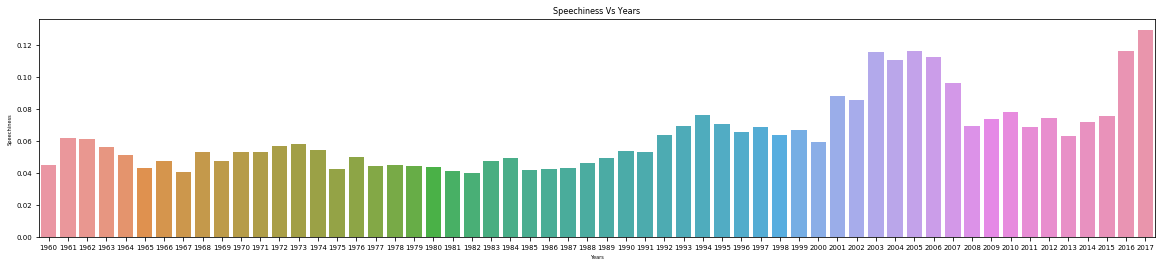

In [6]:
y=list(pd.Series(means.ix['Speechiness',:]))
sns.set_context(rc={"font.size":7,"axes.titlesize":8,"axes.labelsize":5}) 
plt.figure(figsize=(20,4))
sns.barplot(x,y, ci=1)
plt.title('Speechiness Vs Years')
plt.xlabel('Years')
plt.ylabel('Speechiness')

### AVERAGE  NUMBER OF WORDS PER SONG HAS ALMOST DOUBLED IN 2000s AS COMPARED to Pre-2000s
This is mainly due to rise of rap!!

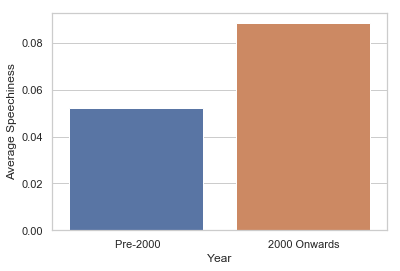

In [10]:
pre=data[data["Year"]<2000].Speechiness.mean()
post=data[data["Year"]>=2000].Speechiness.mean()
_list= []
_list.append((" Pre-2000",pre))
_list.append(("2000 Onwards", post))
smalldf = pd.DataFrame(_list)
smalldf.columns =["Year", "Average Speechiness"]

import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))

sns.barplot(x="Year", y="Average Speechiness", data=smalldf)

### Decline in Acousticness

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Text(0,0.5,'Acousticness')

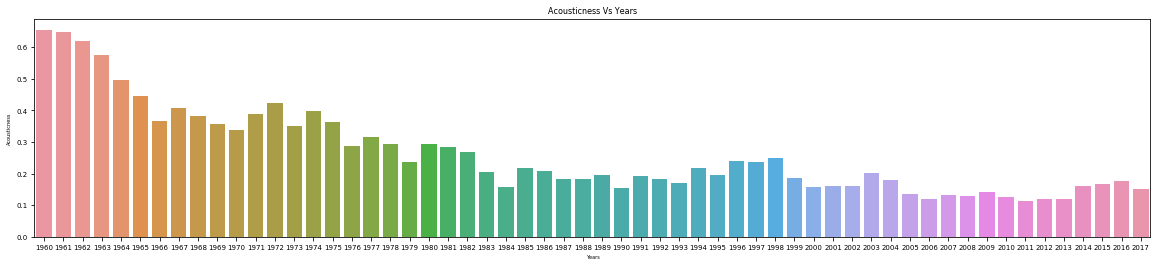

In [7]:
y=list(pd.Series(means.ix['Acousticness',:]))
sns.set_context(rc={"font.size":7,"axes.titlesize":8,"axes.labelsize":5}) 
plt.figure(figsize=(20,4))
sns.barplot(x,y, ci=1)
plt.title('Acousticness Vs Years')
plt.xlabel('Years')
plt.ylabel('Acousticness')